In [1]:
import torchvision
import torch
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import ProjectedGradientDescent
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from torchvision import transforms
from torchvision.io import read_image
from art.estimators.classification import PyTorchClassifier
# from art.attacks.evasion import ProjectedGradientDescentPyTorch
from torchattacks import PGD
from art.utils import random_sphere
from art.config import ART_NUMPY_DTYPE
import numpy as np
from torchvision.transforms import v2
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import os
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, vgg19 , VGG19_Weights, resnet18, ResNet18_Weights, densenet121,  densenet121, DenseNet121_Weights, vit_b_16, ViT_B_16_Weights, efficientnet_b2, EfficientNet_B2_Weights,  swin_s, Swin_S_Weights, convnext_base, ConvNeXt_Base_Weights

/home/baravrah/.conda/envs/gpu_test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/baravrah/.conda/envs/gpu_test/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/baravrah/.conda/envs/gpu_test/lib/python3.8/

In [4]:
import os
os.environ['SLURM_JOBID']

'1126043'

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
models = [("vit_b_16",vit_b_16, ViT_B_16_Weights),
          ("efficientnet_b0" , efficientnet_b0, EfficientNet_B0_Weights),
          ("swin_s", swin_s, Swin_S_Weights),
          ("densenet121" , densenet121, DenseNet121_Weights),
          ("resnet18" ,resnet18, ResNet18_Weights)]

In [6]:
class model_with_normalization(nn.Module):
    def __init__(self, model, normalization):
        super(model_with_normalization, self).__init__()
        self.model = model
        self.normalization = normalization

    def forward(self, x):
        x = self.normalization(x)
        if x.shape == (3,224,224):
          x = x.unsqueeze(0)
        out = self.model(x)
        return out

normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

In [7]:
class CustomDataset(Dataset):
    def __init__(self):
        self.data = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Initialize your custom dataset
new_dataset = CustomDataset()

In [8]:
def read_image(image_path):
    return Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),])

In [9]:
import pickle
import random
from torch.cuda.amp import autocast
trans = [
    transforms.RandomAffine(degrees=(-2, 2), translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(size=(224, 224), padding=10),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast()]


augmentations = transforms.Compose(trans)

batch_size = 100

In [13]:
for i , (name_v, model_v, weights_v) in enumerate(models):
    if i!=3:
        continue
    victim = model_v(weights=weights_v.DEFAULT)
    print("______________________")
    print("Victim: "+ name_v)

    S = models.copy()
    S.pop(i)
    victim = model_with_normalization(victim, normalization)
    victim.eval()
    victim = victim.to(device)



    with open('../data_'+name_v+'1000images.pkl', 'rb') as f: #data that the victim predict the true labels.
        new_data_loader = pickle.load(f)

    #new_data_loader = DataLoader(new_data_loader.dataset, batch_size=batch_size, shuffle=True)

    for j , (name_g,model_g, weights_g) in enumerate(S):
               if j>0:
                  del g
               results_p = {}
               results_a = {}
               results_o = {}
               print("g: "+ name_g)
               g = model_g(weights=weights_g.DEFAULT)
               Se = S.copy()
               Se.pop(j)
               g = model_with_normalization(g, normalization)
               g.eval()
               g = g.to(device)
               for batch , (images, labels) in enumerate(new_data_loader):
                   if batch==1: #for each combination of victim&surrogate, I check only 100 image
                        break
                   perturbation_confidences = []
                   perturbation_success = []

                   augmentations_confidences = []
                   augmentations_success = []

                   augmentation_confidences = []
                   augmentation_success = []
                   images = images.to('cpu')
                   for _ in tqdm(range(1000)):

                        PGD_attack = PGD(g, eps=12.75/255, alpha=random.uniform(0.1/255, 0.3/255), steps =random.randint(10, 20), random_start=True)


                        #random pertubations
                        x_p = PGD_attack(images, labels)
                        adv_label_p = victim(x_p).argmax(dim=1)
                        adv_label_p = adv_label_p.to('cpu')

                        #mixing augmentations
                        x_a = augmentations(images)
                        x_a = PGD_attack(x_a, labels)
                        adv_label_a = victim(x_a).argmax(dim=1)
                        adv_label_a = adv_label_a.to('cpu')

                        #one augmentation
                        x_o = random.choice(trans)(images)
                        x_o = PGD_attack(x_o, labels)
                        adv_label_o = victim(x_o).argmax(dim=1)
                        adv_label_o = adv_label_o.to('cpu')

                        torch.cuda.empty_cache()
                        del PGD_attack

                        average_confidences_p =  np.zeros(batch_size, dtype=np.float32)
                        average_confidences_a =  np.zeros(batch_size, dtype=np.float32)
                        average_confidences_o =  np.zeros(batch_size, dtype=np.float32)
                        
                        for n , model_s, weights_s in Se:

                            model = model_s(weights=weights_s.DEFAULT)
                            model = model.to(device)
                            model = model_with_normalization(model, normalization)
                            model.eval()

                            outputs_p = model(x_p).softmax(dim=1)
                            confidences_p = outputs_p[torch.arange(outputs_p.size(0)),labels].detach().cpu().numpy()
                            average_confidences_p += confidences_p
                            
                            del confidences_p,outputs_p


                            outputs_a = model(x_a).softmax(dim=1)
                            confidences_a = outputs_a[torch.arange(outputs_a.size(0)),labels].detach().cpu().numpy()
                            average_confidences_a += confidences_a

                            
                            del confidences_a,outputs_a


                            outputs_o = model(x_o).softmax(dim=1)
                            confidences_o = outputs_o[torch.arange(outputs_o.size(0)),labels].detach().cpu().numpy()
                            average_confidences_o += confidences_o

                            
                            del model,confidences_o,outputs_o


                            torch.cuda.empty_cache()

                        del x_p,x_a,x_o


                        average_confidences_p /= len(Se)
                        average_confidences_a /= len(Se)
                        average_confidences_o /= len(Se)

                        equality_tensor_p = (labels != adv_label_p).int()
                        equality_tensor_a = (labels != adv_label_a).int()
                        equality_tensor_o = (labels != adv_label_o).int()

                        perturbation_confidences.append(average_confidences_p)
                        perturbation_success.append(equality_tensor_p)
                        augmentations_confidences.append(average_confidences_a)
                        augmentations_success.append(equality_tensor_a)
                        augmentation_confidences.append(average_confidences_o)
                        augmentation_success.append(equality_tensor_o)

                        torch.cuda.empty_cache()

                   del labels,images
                   for i in range(2):
                      if i==1:
                           np.random.seed(111)
                           np.random.shuffle(perturbation_confidences)
                           np.random.seed(111)
                           np.random.shuffle(perturbation_success)

                           np.random.seed(111)
                           np.random.shuffle(augmentations_confidences)
                           np.random.seed(111)
                           np.random.shuffle(augmentations_success)

                           np.random.seed(111)
                           np.random.shuffle(augmentation_confidences)
                           np.random.seed(111)
                           np.random.shuffle(augmentation_success)

                      for size in tqdm(range(1,1001)):
                           merged_results_p = [tuple(zip(np.array(perturbation_confidences)[:size, i], torch.stack(perturbation_success).numpy()[:size, i]))
                                for i in range(batch_size)]

                           merged_results_a = [tuple(zip(np.array(augmentations_confidences)[:size, i], torch.stack(augmentations_success).numpy()[:size, i]))
                                for i in range(batch_size)]

                           merged_results_o = [tuple(zip(np.array(augmentation_confidences)[:size, i], torch.stack(augmentation_success).numpy()[:size, i]))
                                for i in range(batch_size)]



                           # Sort the merged results based on the mean confidence for each image
                           sorted_results_p = [sorted(image_results, key=lambda x: x[0], reverse=False) for image_results in merged_results_p]
                           sorted_results_a = [sorted(image_results, key=lambda x: x[0], reverse=False) for image_results in merged_results_a]
                           sorted_results_o = [sorted(image_results, key=lambda x: x[0], reverse=False) for image_results in merged_results_o]



                           best_result = 0
                           for sublist in sorted_results_p:
                                # Increment the best result based on the first item's binary value
                                best_result += sublist[0][1]
                           results_p[size]=[best_result/100]


                           best_result = 0
                           for sublist in sorted_results_a:
                                # Increment the best result based on the first item's binary value
                                best_result += sublist[0][1]
                           results_a[size]=[best_result/100]


                           best_result = 0
                           for sublist in sorted_results_o:
                                best_result += sublist[0][1]
                           results_o[size]=[best_result/100]
                           torch.cuda.empty_cache()


                      with open('sample_size/Perturbations_100img_'+name_v+'_'+name_g+'_shuffle:'+str(i)+'.pkl', 'wb') as f:
                                pickle.dump(results_p, f)
                      with open('sample_size/mix_augmentations_100img_'+name_v+'_'+name_g+'_shuffle:'+str(i)+'.pkl', 'wb') as f:
                                pickle.dump(results_a, f)
                      with open('sample_size/one_augmentation_100img_'+name_v+'_'+name_g+'_shuffle:'+str(i)+'.pkl', 'wb') as f:
                                pickle.dump(results_o, f)

______________________
Victim: densenet121
g: vit_b_16


100%|██████████| 1000/1000 [03:09<00:00,  5.28it/s]


g: efficientnet_b0


100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s]


g: swin_s


100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s]


g: resnet18


100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


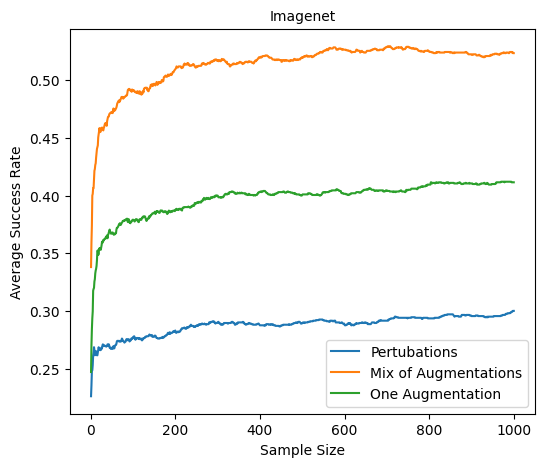

In [13]:
import pickle
#avrage
p_total = {}
o_total = {}
m_total = {}
s=0
s0 = [0 for _ in range(1000)]
s1 = [0 for _ in range(1000)]
s2 = [0 for _ in range(1000)]
for i, (name_v, model_v, weights_v) in enumerate(models):
    S = models.copy()
    S.pop(i)
    for j, (name_g, model_g, weights_g) in enumerate(S):
        with open('sample_size/Perturbations_100img_'+name_v+'_'+name_g+'_shuffle:'+str(s)+'.pkl', 'rb') as f:
            results_p = pickle.load(f)
        with open('sample_size/one_augmentation_100img_'+name_v+'_'+name_g+'_shuffle:'+str(s)+'.pkl', 'rb') as f:
            results_o = pickle.load(f)
        with open('sample_size/mix_augmentations_100img_'+name_v+'_'+name_g+'_shuffle:'+str(s)+'.pkl', 'rb') as f:
            results_a = pickle.load(f)

        # Extracting x and y values for each result
        sizes_p, values_p = zip(*sorted(results_p.items()))
        sizes_a, values_a = zip(*sorted(results_a.items()))
        sizes_o, values_o = zip(*sorted(results_o.items()))
        
        p_total[(i,j)] = [item[0] for item in values_p]
        o_total[(i,j)] = [item[0] for item in values_o]
        m_total[(i,j)] = [item[0] for item in values_a]
        
        p = [x[0] for x in values_p]
        s0 = [a + b for a, b in zip(p, s0)]
        a = [x[0] for x in values_a]
        s2 = [a + b for a, b in zip(a, s2)]
        o = [x[0] for x in values_o]
        s1 = [a + b for a, b in zip(o, s1)]

s0 = [x / 20 for x in s0]
s1 = [x / 20 for x in s1]
s2 = [x / 20 for x in s2]


# Creating plots
plt.figure(figsize=(6,5))

# Plot for results_p
plt.plot(sizes_p, s0, label='Pertubations')

# Plot for results_a
plt.plot(sizes_a, s2, label='Mix of Augmentations')

# Plot for results_o
plt.plot(sizes_o, s1, label='One Augmentation')

# Adding labels and title
plt.xlabel('Sample Size')
plt.ylabel('Average Success Rate')
# plt.suptitle('The effect of the number of pertubations/augmentations on the percentage of success', fontsize=14)
plt.title('Imagenet', fontsize=10)
# Displaying legend
plt.legend()

# Show the plot
plt.show()

In [16]:
with open('sample_size/s0_sample_size_results_cifar.pkl', 'wb') as f:
    pickle.dump(p_total, f)
with open('sample_size/s1_sample_size_results_cifar.pkl', 'wb') as f:
    pickle.dump(o_total, f)
with open('sample_size/s2_sample_size_results_cifar.pkl', 'wb') as f:
    pickle.dump(m_total, f)

In [ ]:
with open('Imagenet_final/sample_size/s0_sample_size_results.pkl', 'rb') as f:
            p_total = pickle.load(f)
with open('Imagenet_final/sample_size/s1_sample_size_results.pkl', 'rb') as f:
    o_total = pickle.load(f)
with open('Imagenet_final/sample_size/s2_sample_size_results.pkl', 'rb') as f:
    a_total = pickle.load(f)

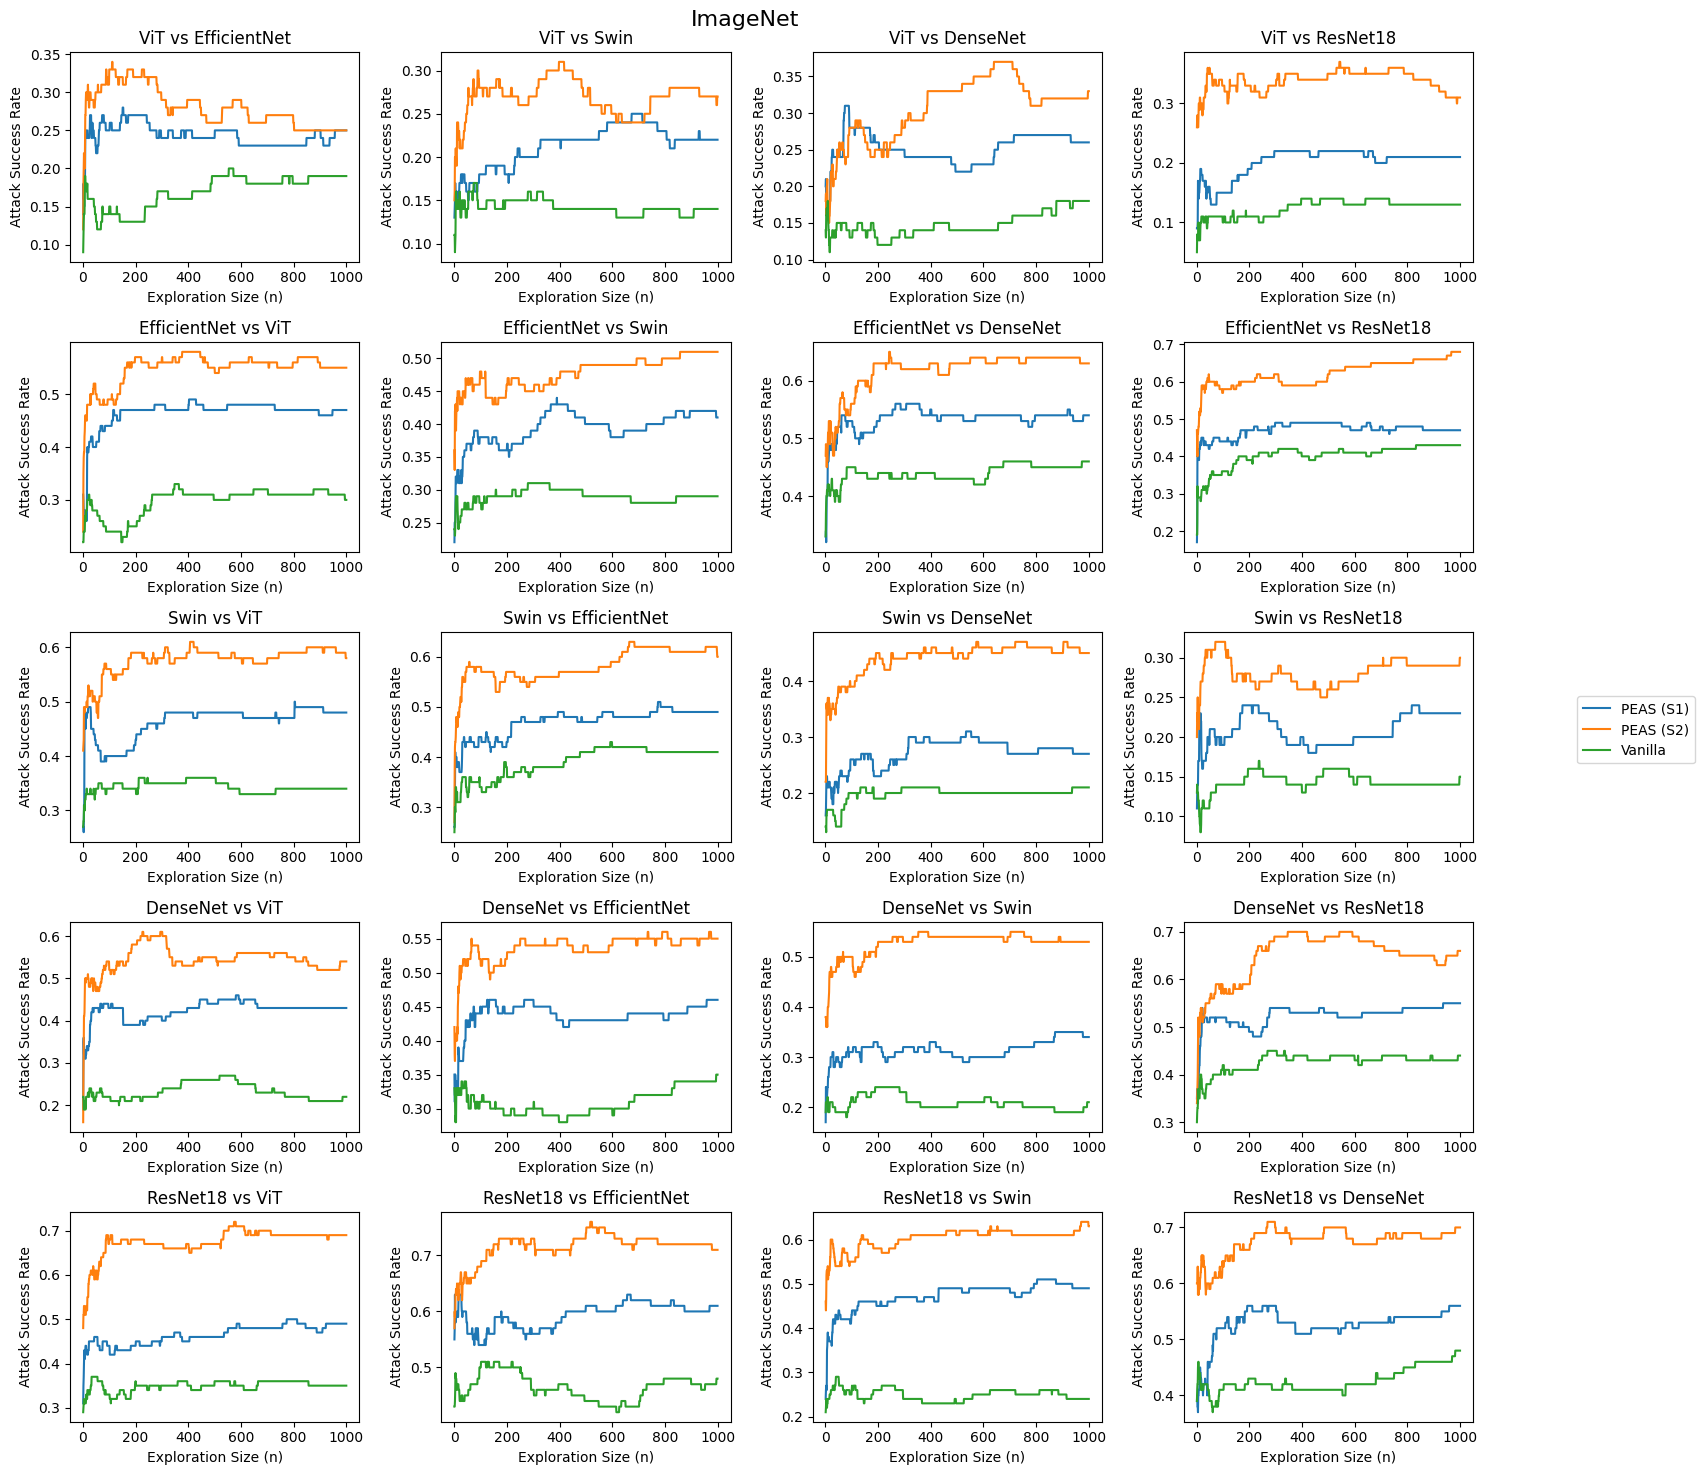

In [15]:
import pickle
models_names = ["ViT",
          "EfficientNet",
          "Swin",
        "DenseNet",
        "ResNet18"]
models = [("vit_b_16",vit_b_16, ViT_B_16_Weights),
          ("efficientnet_b0" , efficientnet_b0, EfficientNet_B0_Weights),
          ("swin_s", swin_s, Swin_S_Weights),
          ("densenet121" , densenet121, DenseNet121_Weights),
          ("resnet18" ,resnet18, ResNet18_Weights)]
s=0
num_rows = 5  # Adjusted to fit 20 plots
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))  # Adjusted figsize to better fit 5 rows

for i, (name_v, model_v, weights_v) in enumerate(models):
    S = models.copy()
    S.pop(i)
    
    S1 = models_names.copy()
    S1.pop(i)
    for j, (name_g, model_g, weights_g) in enumerate(S):
        # Ensure there are enough plots available (only plot if i*num_cols + j is within range)
        if i * num_cols + j >= num_rows * num_cols:
            break  # Prevents plotting beyond available subplots if more combinations are generated

        # File path setup
        base_path = 'number_attacks_per_img/'
        perturb_path = 'sample_size/Perturbations_100img_'+name_v+'_'+name_g+'_shuffle:'+str(s)+'.pkl'
        one_aug_path = 'sample_size/one_augmentation_100img_'+name_v+'_'+name_g+'_shuffle:'+str(s)+'.pkl'
        mix_aug_path = 'sample_size/mix_augmentations_100img_'+name_v+'_'+name_g+'_shuffle:'+str(s)+'.pkl'

        # Load data
        with open(perturb_path, 'rb') as f:
            results_p = pickle.load(f)
        with open(one_aug_path, 'rb') as f:
            results_o = pickle.load(f)
        with open(mix_aug_path, 'rb') as f:
            results_a = pickle.load(f)

        # Extracting x and y values for each result
        sizes_p, values_p = zip(*sorted(results_p.items()))
        sizes_a, values_a = zip(*sorted(results_a.items()))
        sizes_o, values_o = zip(*sorted(results_o.items()))

        # Calculate the position in the grid
        row = (i * num_cols + j) // num_cols  # Integer division to determine row
        col = (i * num_cols + j) % num_cols   # Modulo operation to determine column

        ax = axes[row, col]  # Assign subplot

        # Plot results
        ax.plot(sizes_o, values_o, label='PEAS (S1)')
        ax.plot(sizes_a, values_a, label='PEAS (S2)')
        ax.plot(sizes_p, values_p, label='Vanilla')
        
        ax.set_xlabel('Exploration Size (n)')
        ax.set_ylabel('Attack Success Rate')
        ax.set_title(f'{models_names[i]} vs {S1[j]}')

# Displaying legend outside the loop
common_legend = fig.legend(['PEAS (S1)', 'PEAS (S2)', 'Vanilla'], bbox_to_anchor=(1.05, 0.5), loc='center left')
fig.suptitle('ImageNet', fontsize=16)
# Adjust layout to prevent clipping
fig.subplots_adjust(right=0.85)
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
fig.savefig('ImageNet_full_sample_size.pdf', bbox_inches='tight')